In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.feature_selection import SelectKBest,  chi2
from sklearn import tree
from sklearn.metrics import  roc_curve, roc_auc_score,accuracy_score, precision_recall_fscore_support
from sklearn.metrics import balanced_accuracy_score

from numpy import loadtxt
from sklearn.model_selection import train_test_split,GridSearchCV 
import matplotlib.pyplot as plt

from sklearn.utils import class_weight

import shap
shap.initjs()

In [2]:
# X = pd.read_csv('../data/Training_Data/Training_Dataset_with_ratio.csv')
# repackaged_benign_test_X =  pd.read_csv('../data/Test_Data/Repackaged_Benign_Testset.csv')
# covid_test_X = pd.read_csv('../data/Test_Data/COVID_Testset.csv')

X = pd.read_csv('../data/Training_Data/Training_Dataset_with_threshold.csv')
repackaged_benign_test_X =  pd.read_csv('../data/Test_Data/Repackaged_Benign_Testset.csv')
covid_test_X = pd.read_csv('../data/Test_Data/COVID_Testset.csv')

y = pd.read_csv('../data/Training_Data/Labels_trainingset.csv')
repackaged_benign_test_y = pd.read_csv('../data/Test_Data/Labels_testset.csv')
COVID_test_y = pd.read_csv('../data/Test_Data/Labels_COVID_testset.csv')

In [3]:
# Delete useless features told by Shirish
X.drop(['Package_Name', 'SHA256', 'ThumbPrint', 'Application_Category', 
        'Family_Name', 'Malware_Category', 'Malware/Benign','sdkVersion', 'targetSdkVersion'], axis = 1, inplace = True)

repackaged_benign_test_X.drop(['Package_Name', 'SHA256', 'ThumbPrint', 'Application_Category', 
                               'Family_Name', 'Malware_Category', 'Malware/Benign','sdkVersion', 'targetSdkVersion'], axis = 1, inplace = True)

covid_test_X.drop(['Package_Name', 'SHA256', 'ThumbPrint', 'Application_Category', 
                 'Family_Name', 'Malware_Category', 'Malware/Benign','sdkVersion', 'targetSdkVersion'], axis = 1, inplace = True)

## Feature Exploration

#### Remove features with 0 variance

In [6]:
drop_features = X.max()[X.max() == 0].index.to_list()
X.drop(drop_features, axis = 1, inplace = True)
repackaged_benign_test_X.drop(drop_features, axis = 1, inplace = True)
covid_test_X.drop(drop_features, axis = 1, inplace = True)

In [5]:
# Check if there's no onehot feature has missing values
X.describe().loc['count'][X.describe().loc['count'] < 10954]

Permission: FACTORY_TEST            9538.0
Permission: DUMP                    9538.0
Permission: BATTERY_STATS           9538.0
Permission: BIND_WALLPAPER          9538.0
Permission: BIND_INPUT_METHOD       9538.0
                                     ...  
rotation_vector                     9538.0
temperature                         9538.0
if_the_app_using_suspicious_libs    9538.0
malwareNum                          9538.0
proportion                          9538.0
Name: count, Length: 335, dtype: float64

## Splitting Training and Test set

In [9]:
X['label']=y['label']
# Create dataset without sensor features in order to see if there's some improvement by adding sensor features
sensor_lst=list(X.iloc[:,-14:-3].columns)
# sensor_lst.remove('if_the_app_using_suspicious_libs')
X_wo_sensors = X.drop(sensor_lst, axis = 1)

repackaged_benign_test_X_wo_sensors = repackaged_benign_test_X.drop(sensor_lst, axis = 1)
covid_test_X_wo_sensors = covid_test_X.drop(sensor_lst, axis = 1)


In [10]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, X['label'], 
                                                    test_size = 0.2, 
                                                    random_state = 123, 
                                                    stratify = X['label'])

X_train_wo_sensor, X_test_wo_sensor, y_train_wo_sensor, y_test_wo_sensor = train_test_split(X_wo_sensors, X_wo_sensors['label'], 
                                                                                            test_size = 0.2, 
                                                                                            random_state = 123, 
                                                                                            stratify = X_wo_sensors['label'])

## resample training set

In [11]:
def resample(df):
    gp=df.groupby('label').count().iloc[:,0:1].reset_index().sort_values('label')
    gp.columns=['label','cnt']
    cnt_lst=list(gp['cnt'])
    if cnt_lst[1]-cnt_lst[0]>0:
        x_df_resample=pd.concat([df.query('label==0').sample(n=cnt_lst[1]-cnt_lst[0],random_state=123,replace=True),df])
    else:
        x_df_resample=pd.concat([df.query('label==1').sample(n=cnt_lst[0]-cnt_lst[1],random_state=123,replace=True),df])
    y_df_resample=x_df_resample['label']
    return x_df_resample,y_df_resample

In [12]:
# Train test split
X_train2, X_eval, y_train2, y_eval = train_test_split(X_train, X_train['label'], 
                                                    test_size = 0.1, 
                                                    random_state = 123, 
                                                    stratify = X_train['label'])

X_train2_wo_sensor, X_eval_wo_sensor, y_train2_wo_sensor, y_eval_wo_sensor = train_test_split(X_train_wo_sensor, X_train_wo_sensor['label'], 
                                                                                            test_size = 0.1, 
                                                                                            random_state = 123, 
                                                                                            stratify = X_train_wo_sensor['label'])

In [13]:
X_train_resample,y_train_resample=resample(X_train2)
# X_test_resample,y_test_resample=resample(X_test)

X_train_wo_sensor_resample,y_train_wo_sensor_resample=resample(X_train2_wo_sensor)
# X_test_wo_sensor_resample,y_test_wo_sensor_resample=resample(X_test_wo_sensor)


# Visualizing Dataset


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


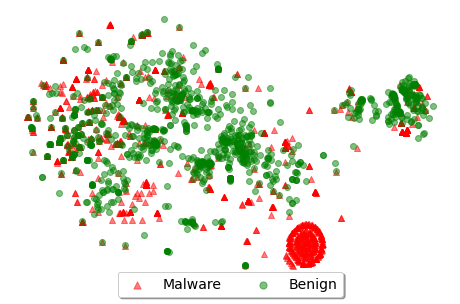

In [12]:
from sklearn.manifold import TSNE

combined_data = X.copy()
combined_data['Ground_Truth'] = y

# Separate malware and benign dataset to plot
df_malware = combined_data[combined_data['Ground_Truth'] == 1]
df_benign = combined_data[combined_data['Ground_Truth'] == 0]

# Drop the ground truth column
df_malware.drop(['Ground_Truth'], axis=1, inplace=True)
df_benign.drop(['Ground_Truth'], axis=1, inplace=True)

df_malware = pd.DataFrame(df_malware).sample(frac = 0.13, random_state=0)
m_rd_features = df_malware

df_benign = pd.DataFrame(df_benign).sample(frac = 0.5, random_state=0) 
b_rd_features = df_benign

X_embedded = TSNE(n_components=2, init='pca', random_state=0, perplexity=300).fit_transform(np.concatenate((m_rd_features,b_rd_features),axis=0))

plt.subplots(figsize=(8,5))
plt.axis('off')
plt.scatter(X_embedded[:m_rd_features.shape[0], 0], X_embedded[:m_rd_features.shape[0], 1], marker ='^', c='red',alpha=0.5)
plt.scatter(X_embedded[m_rd_features.shape[0]:, 0], X_embedded[m_rd_features.shape[0]:, 1], marker = 'o', c='green',alpha=0.5)
plt.legend(['Malware','Benign'], loc='upper center', bbox_to_anchor=(0.5, 0.05),
          fancybox=True, shadow=True, ncol=5, markerscale=1.2, 
          fontsize=14)
#plt.savefig("safe_learning.png")
plt.show()

# Neural Network

In [14]:
import tensorflow as tf
from tensorflow import keras
import IPython

In [19]:
# !conda install -c conda-forge keras-tuner

In [15]:
import kerastuner as kt

In [16]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.losses import categorical_crossentropy as logloss
from keras.utils import np_utils
from keras.layers import Dropout
from keras.optimizers import adam


Using TensorFlow backend.


In [18]:
## keras-tunner--- cannot add dropout layer ---- not useful enough
def model_builder(hp):
    tf.keras.backend.clear_session()
    model = keras.Sequential()
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 16-64
    hp_units1 = hp.Int('units1', min_value = 16, max_value = 64, step = 16)
    model.add(keras.layers.Dense(units = hp_units1, activation = 'relu'))
    model.add(keras.layers.Dropout(0.4))
    hp_units2 = hp.Int('units2', min_value = 16, max_value = 64, step = 16)
    model.add(keras.layers.Dense(units = hp_units2, activation = 'relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(1,activation='sigmoid'))

    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-1,1e-2, 1e-3, 1e-4]) 
    
#     model.compile(loss='binary_crossentropy', optimizer=adam(lr=1e-4, decay=1e-6), metrics=[tf.keras.metrics.AUC(),'accuracy'])

    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.BinaryCrossentropy(from_logits = True), 
                metrics=[tf.keras.metrics.Precision()])
    return model


In [22]:
tf.keras.backend.clear_session()

tuner = kt.Hyperband(model_builder,
                     kt.Objective("val_precision", direction="max"),
                     max_epochs = 10,
                     factor = 3,
                     directory = 'dnn_model_training',
                     project_name = '2_layers',
                     overwrite = True)   

# tuner = kt.RandomSearch(
#     model_builder,
#     objective='val_accuracy',
#     max_trials=20,
#     executions_per_trial=3,
#     directory='dnn_model_training',
#     project_name='2_layers',
#     overwrite = True) 

In [20]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [23]:
tuner.search(X_train_resample.drop(['malwareNum','proportion','label'],axis=1).values, y_train_resample.values, epochs = 20, 
             validation_data=(X_test.drop(['malwareNum','proportion','label'],axis=1).values, y_test.values),verbose=2, 
             callbacks = [ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [24]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(f"""
The hyperparameter search is complete. \n
The optimal number of units in the first densely-connected layer is {best_hps.get('units1')} \n
The optimal number of units in the second densely-connected layer is {best_hps.get('units2')} \n
The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. 

The optimal number of units in the first densely-connected layer is 32 

The optimal number of units in the second densely-connected layer is 48 

The optimal learning rate for the optimizer
is 0.0001.



In [25]:
tf.keras.backend.clear_session()
tuner = kt.Hyperband(model_builder,
                     kt.Objective("val_precision", direction="max"),
                     max_epochs = 10,
                     factor = 3,
                     directory = 'dnn_model_training',
                     project_name = '2_layers_wo_sensor',
                     overwrite = True)   

# tuner = kt.RandomSearch(
#     model_builder,
#     objective='val_accuracy',
#     max_trials=20,
#     executions_per_trial=3,
#     directory='dnn_model_training',
#     project_name='2_layers',
#     overwrite = True) 

tuner.search(X_train_wo_sensor_resample.drop(['malwareNum','proportion','label'],axis=1).values,y_train_wo_sensor_resample.values, epochs = 20,
             validation_split=0.2,verbose=2,
             callbacks = [ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [26]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(f"""
The hyperparameter search is complete. \n
The optimal number of units in the first densely-connected layer is {best_hps.get('units1')} \n
The optimal number of units in the second densely-connected layer is {best_hps.get('units2')} \n
The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. 

The optimal number of units in the first densely-connected layer is 64 

The optimal number of units in the second densely-connected layer is 48 

The optimal learning rate for the optimizer
is 0.0001.



### bayesian optimizer

In [17]:
seed = 112 # Random seed
def dnn_with_sensor(dropout1,dropout2,neural1,neural2,learning_rate):
    from sklearn.metrics import roc_auc_score,f1_score
    import numpy as np
    tf.keras.backend.clear_session()
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = neural1, activation = 'relu'))
    model.add(keras.layers.Dropout(dropout1))
    model.add(keras.layers.Dense(units = neural2, activation = 'relu'))
    model.add(keras.layers.Dropout(dropout2))
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
                loss = keras.losses.BinaryCrossentropy(from_logits = True), 
                metrics = ['accuracy'])
    
    model.fit(X_train_resample.drop('label',axis=1).values, y_train_resample.values, epochs = 20, verbose=False)
    y_pred=model.predict(X_test.drop('label',axis=1).values)
    val1_roc = f1_score(y_test,np.round(y_pred))
    return val1_roc

In [22]:
seed = 112 # Random seed
def dnn_wo_sensor(dropout1,dropout2,neural1,neural2,learning_rate):
    from sklearn.metrics import roc_auc_score,f1_score
    import numpy as np
    tf.keras.backend.clear_session()
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = neural1, activation = 'relu'))
    model.add(keras.layers.Dropout(dropout1))
    model.add(keras.layers.Dense(units = neural2, activation = 'relu'))
    model.add(keras.layers.Dropout(dropout2))
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
                loss = keras.losses.BinaryCrossentropy(from_logits = True), 
                metrics = ['accuracy'])
    
    model.fit(X_train_wo_sensor_resample.drop('label',axis=1).values,
              y_train_wo_sensor_resample.values, epochs = 20, verbose=False)
    
    y_pred=model.predict(X_test_wo_sensor.drop('label',axis=1).values)
    val1_roc = f1_score(y_test,np.round(y_pred))
    return val1_roc

In [23]:
import warnings
warnings.filterwarnings('ignore')

from bayes_opt import BayesianOptimization

gp_params = {"alpha": 1e-10}

seed = 112 # Random seed

hyperparameter_space = {
    'dropout1': (0.4, 0.5),
    'dropout2': (0.4, 0.5),
    'neural1':(16,64),
    'neural2':(16,64),
    'learning_rate': (0.001,0.001),
}

dnnBO = BayesianOptimization(f = dnn_with_sensor, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

dnnBO.maximize(init_points=3,n_iter=10,acq='ucb', kappa= 3, **gp_params)


|   iter    |  target   | dropout1  | dropout2  | learni... |  neural1  |  neural2  |
-------------------------------------------------------------------------------------
|  1        |  0.877    |  0.4375   |  0.464    |  0.001    |  19.63    |  53.29    |
|  2        |  0.8757   |  0.4833   |  0.4055   |  0.001    |  58.5     |  50.67    |
|  3        |  0.8663   |  0.4003   |  0.4981   |  0.001    |  20.55    |  34.94    |
|  4        |  0.8672   |  0.4904   |  0.4677   |  0.001    |  19.71    |  53.38    |
|  5        |  0.877    |  0.4128   |  0.4231   |  0.001    |  34.62    |  19.87    |
|  6        |  0.8755   |  0.426    |  0.426    |  0.001    |  54.22    |  49.52    |
|  7        |  0.8723   |  0.4383   |  0.4854   |  0.001    |  48.33    |  32.19    |
|  8        |  0.8755   |  0.4662   |  0.456    |  0.001    |  52.37    |  43.44    |
|  9        |  0.8755   |  0.4222   |  0.4906   |  0.001    |  58.34    |  62.48    |
|  10       |  0.8653   |  0.4194   |  0.4433   |  0.0

### model training

In [32]:
tf.keras.backend.clear_session()
model = keras.Sequential()
model = Sequential()
model.add(Dense(32, input_dim=X_train_resample.drop(['malwareNum','proportion','label'],axis=1).shape[1], activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.4))
# model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=adam(lr=0.0001), metrics=['accuracy',tf.keras.metrics.AUC()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                10688     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 48)                1584      
_________________________________________________________________
dropout_2 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 49        
Total params: 12,321
Trainable params: 12,321
Non-trainable params: 0
_________________________________________________________________


In [33]:
history=model.fit(X_train_resample.drop(['malwareNum','proportion','label'],axis=1).values, y_train_resample.values,
#                   validation_split=0.2,
                  validation_data=(X_test.drop(['malwareNum','proportion','label'],axis=1).values, y_test),
                  verbose=2,
                  epochs=100,batch_size=32)
# history = model.fit(X_train, y_train, validation_split=0.2,epochs=50,batch_size=32, shuffle=True)

Train on 10848 samples, validate on 1908 samples
Epoch 1/100
 - 3s - loss: 0.6530 - accuracy: 0.6037 - auc: 0.5965 - val_loss: 0.5537 - val_accuracy: 0.8234 - val_auc: 0.6774
Epoch 2/100
 - 2s - loss: 0.5556 - accuracy: 0.7241 - auc: 0.7233 - val_loss: 0.4616 - val_accuracy: 0.8103 - val_auc: 0.7589
Epoch 3/100
 - 2s - loss: 0.4785 - accuracy: 0.7798 - auc: 0.7830 - val_loss: 0.4054 - val_accuracy: 0.8155 - val_auc: 0.8040
Epoch 4/100
 - 2s - loss: 0.4248 - accuracy: 0.8107 - auc: 0.8192 - val_loss: 0.3754 - val_accuracy: 0.8187 - val_auc: 0.8315
Epoch 5/100
 - 2s - loss: 0.3888 - accuracy: 0.8249 - auc: 0.8413 - val_loss: 0.3523 - val_accuracy: 0.8333 - val_auc: 0.8503
Epoch 6/100
 - 2s - loss: 0.3617 - accuracy: 0.8403 - auc: 0.8577 - val_loss: 0.3409 - val_accuracy: 0.8386 - val_auc: 0.8643
Epoch 7/100
 - 2s - loss: 0.3506 - accuracy: 0.8442 - auc: 0.8700 - val_loss: 0.3132 - val_accuracy: 0.8454 - val_auc: 0.8748
Epoch 8/100
 - 2s - loss: 0.3314 - accuracy: 0.8520 - auc: 0.8794 - v

In [34]:
# Plot Accuracy
def plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Plot Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Plot Loss
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Model auc')
    plt.ylabel('auc')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

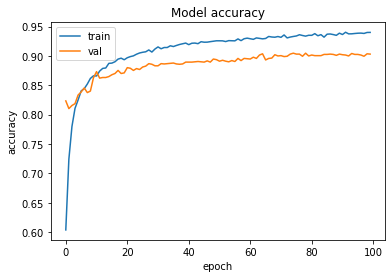

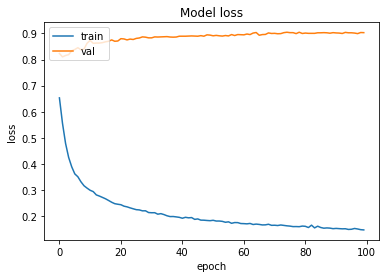

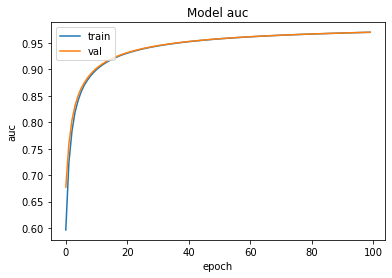

In [39]:
plot(history)

In [40]:
## predict using sensor model
y_pred_with_sensor = model.predict(X_test.drop(['malwareNum','proportion','label'],axis=1).values)
y_pred_repack_benign = model.predict_proba(repackaged_benign_test_X)
covid_test_X.fillna(0, inplace = True)
# covid_y_pred_w_sensor = model.predict_proba(covid_test_X)

## model without sensor

In [41]:
tf.keras.backend.clear_session()
model_wo = keras.Sequential()
model_wo = Sequential()
model_wo.add(Dense(48, input_dim=X_train_wo_sensor_resample.drop(['malwareNum','proportion','label'],axis=1).shape[1], activation='relu'))
model_wo.add(Dropout(0.4))
model_wo.add(Dense(64, activation='relu'))
model_wo.add(Dropout(0.4))
# model.add(Dense(128, activation='relu'))
model_wo.add(Dense(1, activation='sigmoid'))

# Compile model
model_wo.compile(loss='binary_crossentropy', optimizer=adam(lr=0.001), metrics=['accuracy',tf.keras.metrics.AUC()])
model_wo.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 48)                15504     
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                3136      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 18,705
Trainable params: 18,705
Non-trainable params: 0
_________________________________________________________________


In [42]:
history_wo=model_wo.fit(X_train_wo_sensor_resample.drop(['malwareNum','proportion','label'],axis=1).values, y_train_wo_sensor_resample.values,
                  validation_data=(X_test_wo_sensor.drop(['malwareNum','proportion','label'],axis=1).values, y_test_wo_sensor),
                  epochs=100,batch_size=32,verbose=2)
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=50,batch_size=32, shuffle=True)

Train on 10848 samples, validate on 1908 samples
Epoch 1/100
 - 3s - loss: 0.4458 - accuracy: 0.7771 - auc: 0.7864 - val_loss: 0.3259 - val_accuracy: 0.8664 - val_auc: 0.8783
Epoch 2/100
 - 2s - loss: 0.3112 - accuracy: 0.8625 - auc: 0.8999 - val_loss: 0.3154 - val_accuracy: 0.8611 - val_auc: 0.9148
Epoch 3/100
 - 1s - loss: 0.2791 - accuracy: 0.8811 - auc: 0.9224 - val_loss: 0.2824 - val_accuracy: 0.8742 - val_auc: 0.9289
Epoch 4/100
 - 2s - loss: 0.2574 - accuracy: 0.8918 - auc: 0.9335 - val_loss: 0.2737 - val_accuracy: 0.8768 - val_auc: 0.9375
Epoch 5/100
 - 2s - loss: 0.2405 - accuracy: 0.8977 - auc: 0.9403 - val_loss: 0.2766 - val_accuracy: 0.8700 - val_auc: 0.9432
Epoch 6/100
 - 2s - loss: 0.2343 - accuracy: 0.9023 - auc: 0.9451 - val_loss: 0.2708 - val_accuracy: 0.8810 - val_auc: 0.9472
Epoch 7/100
 - 2s - loss: 0.2246 - accuracy: 0.9075 - auc: 0.9488 - val_loss: 0.2712 - val_accuracy: 0.8747 - val_auc: 0.9503
Epoch 8/100
 - 2s - loss: 0.2157 - accuracy: 0.9129 - auc: 0.9517 - v

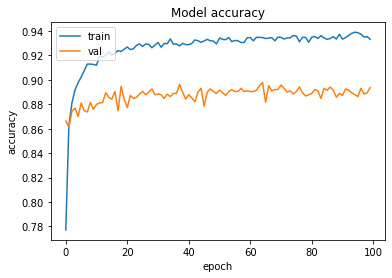

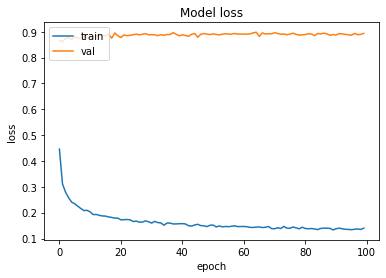

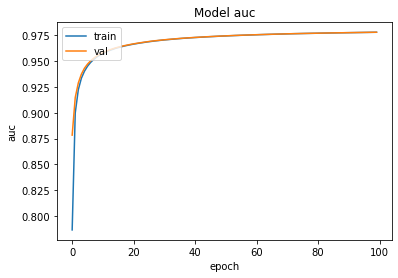

In [46]:
plot(history_wo)

In [47]:
y_pred_wo_sensor = model_wo.predict(X_test_wo_sensor.drop(['malwareNum','proportion','label'],axis=1).values)
y_pred_repack_benign_wo_sensor = model_wo.predict_proba(repackaged_benign_test_X_wo_sensors)
# covid_y_pred_wo_sensor = model_wo.predict_proba(covid_test_X_wo_sensors)

## TESTING

AUC (including sensor features) 0.9573006766428322
AUC (not including sensor features) 0.9320767424504433


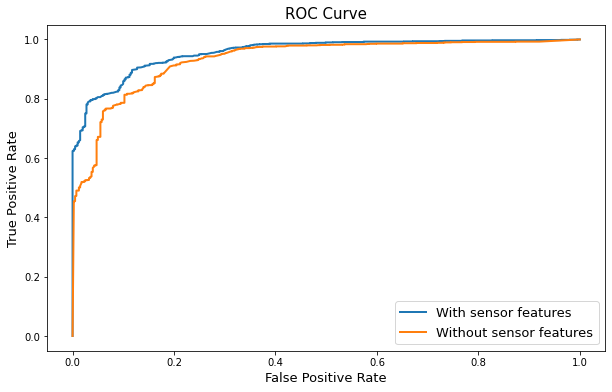

In [48]:
plt.figure(figsize = (10, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_with_sensor)
fpr2, tpr2, _2 = roc_curve(y_test_wo_sensor, y_pred_wo_sensor)
plt.plot(fpr, tpr, lw=2, label='With sensor features')
plt.plot(fpr2, tpr2, lw=2, label='Without sensor features')
print('AUC (including sensor features)', roc_auc_score(y_test, y_pred_with_sensor))
print('AUC (not including sensor features)', roc_auc_score(y_test, y_pred_wo_sensor))

plt.xlabel('False Positive Rate', fontsize = 13)
plt.ylabel('True Positive Rate', fontsize = 13)
plt.title('ROC Curve', fontsize = 15)
plt.legend(fontsize = 13)

In [49]:
precision_recall_fscore_support(y_test, np.round(y_pred_with_sensor))

(array([0.74770642, 0.94904891]),
 array([0.81296758, 0.9270073 ]),
 array([0.77897252, 0.93789862]),
 array([ 401, 1507]))

In [50]:
precision_recall_fscore_support(y_test, np.round(y_pred_wo_sensor))

(array([0.73684211, 0.93758389]),
 array([0.7680798, 0.9270073]),
 array([0.75213675, 0.9322656 ]),
 array([ 401, 1507]))

In [51]:
tp_0=(np.array([1]*y_pred_wo_sensor.shape[0])-y_pred_wo_sensor[:,0]).reshape(-1,1)
prob_wo=np.stack([tp_0[:,0],y_pred_wo_sensor[:,0]],axis=1)

tp_0=(np.array([1]*y_pred_with_sensor.shape[0])-y_pred_with_sensor[:,0]).reshape(-1,1)
prob=np.stack([tp_0[:,0],y_pred_with_sensor[:,0]],axis=1)

In [52]:
with open('../../dnn_pred_with_sensor.npy', 'wb') as f:
    np.save(f, prob)
with open('../../dnn_pred_wo_sensor.npy', 'wb') as f:
    np.save(f, prob_wo)

## Other Metrics

In [53]:
print('Balanced Average Accuracy (including sensor features):', balanced_accuracy_score(y_test, np.round(y_pred_with_sensor)))
print('Balanced Average Accuracy (not including sensor features):', balanced_accuracy_score(y_test, np.round(y_pred_wo_sensor)))

Balanced Average Accuracy (including sensor features): 0.8699874401587273
Balanced Average Accuracy (not including sensor features): 0.847543549884413


## Paired or Non-paired

In [55]:
pairs = pd.read_csv('../../repackaging_pairs.txt')
# Train test split
X_ = pd.read_csv('../data/Training_Data/Training_Dataset_with_threshold.csv')
y_ = pd.read_csv('../data/Training_Data/Labels_trainingset.csv')

# X = pd.read_csv('../data/Training_Data/Training_Dataset_with_ratio.csv')
# repackaged_benign_test_X =  pd.read_csv('../data/Test_Data/Repackaged_Benign_Testset.csv')
# covid_test_X = pd.read_csv('../data/Test_Data/COVID_Testset.csv')

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_,y_['label'], 
                                                    test_size = 0.2, 
                                                    random_state = 123, 
                                                    stratify = y_['label'])

In [56]:
paired_w_sensor_accuracy = []
non_paired_w_sensor_accuracy = []
paired_wo_sensor_accuracy = []
non_paired_wo_sensor_accuracy = []

visited = []
for i in range(X_test_.shape[0]):
    acc1 = np.round(y_pred_with_sensor[i])  == y_test_.iloc[i]
    acc2 =np.round(y_pred_wo_sensor[i]) == y_test_.iloc[i]
    
    sha = X_test_.iloc[i]['SHA256']
    
    for idx in pairs.index:
        if sha == pairs.loc[idx, 'SHA256_ORIGINAL']:
            if pairs.loc[idx, 'SHA256_REPACKAGE'] in X_test_['SHA256'].values:
                paired_w_sensor_accuracy.append(acc1)
                paired_wo_sensor_accuracy.append(acc2)
            else:
                non_paired_w_sensor_accuracy.append(acc1)
                non_paired_wo_sensor_accuracy.append(acc2)
            break
        elif sha == pairs.loc[idx, 'SHA256_REPACKAGE']:
            if pairs.loc[idx, 'SHA256_ORIGINAL'] in X_test_['SHA256'].values:
                paired_w_sensor_accuracy.append(acc1)
                paired_wo_sensor_accuracy.append(acc2)
            else:
                non_paired_w_sensor_accuracy.append(acc1)  
                non_paired_wo_sensor_accuracy.append(acc2)  
            break

In [57]:
acc_1 = []
acc_2 = []
for i in range(X_test.shape[0]):
    acc1 = np.round(y_pred_with_sensor[i]) == y_test.iloc[i]
    acc2 = np.round(y_pred_wo_sensor[i])== y_test.iloc[i]
    
    acc_1.append(acc1)
    acc_2.append(acc2)

In [58]:
np.sum(acc_1)
np.sum(paired_w_sensor_accuracy)
np.sum(non_paired_w_sensor_accuracy)

1585

In [54]:
print("Accuracy for paired apps (including sensor features):", np.sum(paired_w_sensor_accuracy)/len(paired_w_sensor_accuracy))
print("Accuracy for non-paired apps (including sensor features):", np.sum(non_paired_w_sensor_accuracy)/len(non_paired_w_sensor_accuracy))

print("Accuracy for paired apps (not including sensor features):", np.sum(paired_wo_sensor_accuracy)/len(paired_wo_sensor_accuracy))
print("Accuracy for non-paired apps (not including sensor features):", np.sum(non_paired_wo_sensor_accuracy)/len(non_paired_wo_sensor_accuracy))

Accuracy for paired apps (including sensor features): 0.8193832599118943
Accuracy for non-paired apps (including sensor features): 0.8701947079380928
Accuracy for paired apps (not including sensor features): 0.8722466960352423
Accuracy for non-paired apps (not including sensor features): 0.8706939590614079


In [59]:
print("Accuracy for paired apps (including sensor features):", np.sum(paired_w_sensor_accuracy)/len(paired_w_sensor_accuracy))
print("Accuracy for non-paired apps (including sensor features):", np.sum(non_paired_w_sensor_accuracy)/len(non_paired_w_sensor_accuracy))

print("Accuracy for paired apps (not including sensor features):", np.sum(paired_wo_sensor_accuracy)/len(paired_wo_sensor_accuracy))
print("Accuracy for non-paired apps (not including sensor features):", np.sum(non_paired_wo_sensor_accuracy)/len(non_paired_wo_sensor_accuracy))

Accuracy for paired apps (including sensor features): 0.8571428571428571
Accuracy for non-paired apps (including sensor features): 0.9072696050372067
Accuracy for paired apps (not including sensor features): 0.8509316770186336
Accuracy for non-paired apps (not including sensor features): 0.8975386376645679


## Testing on Repackaged Benign Apps Dataset

In [59]:
# accuracy = accuracy_score.score(repackaged_benign_test_X, repackaged_benign_test_y['label'].values)
# print('Accuracy (including sensor features):', accuracy)

In [60]:
# y_pred_repack_benign = pipe_with_sensor.predict_proba(repackaged_benign_test_X)
# y_pred_repack_benign_wo_sensor = pipe_without_sensor.predict_proba(repackaged_benign_test_X_wo_sensors)
accuracy = accuracy_score(repackaged_benign_test_y['label'],np.round(y_pred_repack_benign))
print('Accuracy (including sensor features):', accuracy)
accuracy = accuracy_score(repackaged_benign_test_y['label'],np.round(y_pred_repack_benign_wo_sensor))
print('Accuracy (without sensor features):', accuracy)

Accuracy (including sensor features): 0.8848845346396081
Accuracy (without sensor features): 0.9688593421973408


## Testing on covid-19

In [57]:
# print('Balanced Average Accuracy (including sensor features):', balanced_accuracy_score(COVID_test_y['label'].values, np.round(covid_y_pred_w_sensor)))
# print('Balanced Average Accuracy (not including sensor features):', balanced_accuracy_score(COVID_test_y['label'].values, np.round(covid_y_pred_wo_sensor)))

## Thumbprint Score

In [58]:
X_test_['y_pred_with_sensor'] = np.round(y_pred_with_sensor)
X_test_['y_pred_wo_sensor'] = np.round(y_pred_wo_sensor)
X_test_['label'] = y_test


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [59]:
X_test_['y_pred_wo_sensor']

5927    1.0
5505    1.0
5249    1.0
9252    1.0
3160    0.0
       ... 
92      0.0
6127    0.0
7364    1.0
6704    1.0
4803    1.0
Name: y_pred_wo_sensor, Length: 2230, dtype: float32

In [60]:
# scores of top 10 authors
X_test_['correct'] = X_test_['label'] == X_test_['y_pred_with_sensor']
summ = X_test_[X_test_['label']==1].groupby('ThumbPrint').agg(N=('SHA256','count'),
                                                              correct=('correct','sum'))\
.sort_values(['N','correct'], ascending=False).iloc[:10,:].reset_index()
summ['score'] = summ['correct']/summ['N']
summ


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ThumbPrint,N,correct,score
0,61ED377E85D386A8DFEE6B864BD85B0BFAA5AF81,162,114,0.703704
1,28EAC321D548B4247D9C84810C0656EC9426716B,97,75,0.773196
2,F3FA0BE3FEB31AC2920E399AF0F0CFB37D729284,71,71,1.000000
3,95653B2BD67722B6EF4021CB812FF2B4DC5DCF03,67,67,1.000000
4,00F7DCC41988D8642C51D4F8BA5A42C413275885,58,58,1.000000
5,F243B92AD5EABA98BD43084864C4D5483F191CD9,52,41,0.788462
6,45A195BE1E17B3AFA086623DCC4661DEE2043B70,45,45,1.000000
7,6C699C8D1F7157366994ACDA5495051F2C58D7AB,44,44,1.000000
8,699512C8B49E7A01A622BD250544E09A80A42D55,39,32,0.820513
9,5BFC55F389F4B5427341E4320A501711140AE444,35,18,0.514286


In [61]:
# scores of top 10 authors
X_test_['correct'] = X_test_['label'] == X_test_['y_pred_wo_sensor']
summ = X_test_[X_test_['label']==1].groupby('ThumbPrint').agg(N=('SHA256','count'),
                                                      correct=('correct','sum'))\
.sort_values(['N','correct'], ascending=False).iloc[:10,:].reset_index()
summ['score'] = summ['correct']/summ['N']
summ


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ThumbPrint,N,correct,score
0,61ED377E85D386A8DFEE6B864BD85B0BFAA5AF81,162,120,0.740741
1,28EAC321D548B4247D9C84810C0656EC9426716B,97,85,0.876289
2,F3FA0BE3FEB31AC2920E399AF0F0CFB37D729284,71,71,1.000000
3,95653B2BD67722B6EF4021CB812FF2B4DC5DCF03,67,67,1.000000
4,00F7DCC41988D8642C51D4F8BA5A42C413275885,58,58,1.000000
5,F243B92AD5EABA98BD43084864C4D5483F191CD9,52,43,0.826923
6,45A195BE1E17B3AFA086623DCC4661DEE2043B70,45,45,1.000000
7,6C699C8D1F7157366994ACDA5495051F2C58D7AB,44,44,1.000000
8,699512C8B49E7A01A622BD250544E09A80A42D55,39,37,0.948718
9,5BFC55F389F4B5427341E4320A501711140AE444,35,19,0.542857


# SHAP FOR MISCLASSIFICATION

In [62]:
def compute_changes(row):
    if row['feature_importance_vals_true']*row['feature_importance_vals_false']<0:
        return 1
    else:
        return 0

class SHAP_Visual_ThumbPrint:  ## use shap to explain the prediction results of a thumbprint for a certain model
    def __init__(self,thumbprint,X_train,X_test,model,model_name,feature_lst,link='logit'):
        '''
        thumbprint: the thumbprint of one author
        X_test: from which dataframe to get the author information
        model_with_sensor: the model trained using sensor information
        model_wo_sensor: the model trained without sensor information
        '''
        self.thumbprint = thumbprint
        self.model = model
        self.model_name=model_name         ## model_name is related to the type of shap explainer
        self.X_train=X_train               ## useful for linear_explainer and dnn_explainer because this provides background distribution of training set
        self.X_test=X_test                ## useful only for get_prediction_records of a certain type (eg:correct classifications, misclassifications)
        
        self.get_pred_record(thumbprint,feature_lst) ## init author dataframes
        self.init_explainer() ## init explainer
        self.feature_lst=feature_lst
        
        
    def combine_feature_importance_all(self):  ## combine the feature importance of misclsfy and clsfy
        feature_importance_correct=self.compute_feature_importance(self.author_true_df)
        feature_importance_false=self.compute_feature_importance(self.author_false_df)
        feature_importance_merge=feature_importance_correct.merge(feature_importance_false,how='inner',on='col_name')
        return feature_importance_merge
        
    def get_pred_record(self,thumbprint,feature_lst): ## just filter author dataframe for shap_value computations
        author=self.X_test.query(f'ThumbPrint=="{thumbprint}"').query('label==1')
#         print(author.groupby('correct').agg(cnt=('SHA256','count')).reset_index())
        author_true=author.query('correct==1')
        author_false=author.query('correct==0')
#         return author[feature_lst],author_true[feature_lst],author_false[feature_lst]
        self.author_df=author[feature_lst]              ## features of apps of an author (thumbprint)
        self.author_true_df=author_true[feature_lst]    ## features of all correct classifications of an author (thumbprint)
        self.author_false_df=author_false[feature_lst]  ## features of all misclassifications of an author (thumbprint)
        
        
    def init_explainer(self):
        ## useful link about shap models:
        ## https://shap.readthedocs.io/en/latest/examples.html#linear-explainer-examples
        if self.model_name.lower() in {'xgboost','xgb'}:
            self.explainer= shap.TreeExplainer(self.model)
        elif self.model_name.lower() in {'logistic_regression','LR','logistic regression'}:
            self.explainer=shap.LinearExplainer(self.model,self.X_train)
            ## The background dataset to use for computing conditional expectations. 
            ## Note that only the mean and covariance of the dataset are used. 
            ## This means passing a raw data matrix is just a convienent alternative to passing the mean and covariance directly.
        elif self.model_name.lower() in {'dnn'}: ## useful for both keras model (framework ='pytorch') and pytorch model (framework ='pytorch')
            self.explainer=shap.DeepExplainer(self.model,self.X_train.sample(n=1000,replace=0).values)
            
            ## why select 100 or 1000 from x_train:
            ## The background dataset to use for integrating out features. 
            ## Deep integrates over these samples. 
            ## The data passed here must match the input tensors given in the first argument(model). 
            ## Note that since these samples are integrated over for each sample 
            ## you should only something like 100 or 1000 random background samples, not the whole training dataset.
        else:
            self.explainer=shap.KernelExplainer(self.model,self.X_train,link='logit')
            ## A generalized linear model link to connect the feature importance values to the model output. 
            ## Since the feature importance values, phi, sum up to the model output, 
            ## it often makes sense to connect them to the output with a link function where link(output) = sum(phi). 
            ## If the model output is a probability then the LogitLink link function makes the feature importance values have log-odds units.
            
    def compute_feature_importance(self,df): ## compute feature_importance for a dataframe
        shap_values = self.explainer.shap_values(df)
        vals= np.abs(shap_values).mean(0)
        feature_importance = pd.DataFrame(list(zip(df.columns,vals)),columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
        feature_importance['rank']=list(range(1,feature_importance.shape[0]+1))
        feature_importance['ThumbPrint']=self.thumbprint
        
        return feature_importance

    def combine_feature_importance_all(self):  ## combine the feature importance of misclsfy and clsfy
        feature_importance_correct=self.compute_feature_importance(self.author_true_df[self.feature_lst])
        feature_importance_false=self.compute_feature_importance(self.author_false_df[self.feature_lst])
        feature_importance_merge=feature_importance_correct.merge(feature_importance_false,how='inner',on=['col_name','ThumbPrint'],suffixes=['_true','_false'])
        feature_importance_merge['importance_change']=feature_importance_merge['feature_importance_vals_true']-feature_importance_merge['feature_importance_vals_false'] 
        feature_importance_merge['rank_change']=feature_importance_merge['rank_true']-feature_importance_merge['rank_false']
        feature_importance_merge['change_direction']=feature_importance_merge.apply(lambda x:compute_changes(x),axis=1)
        return feature_importance_merge 
    
    def summary_plot(self,df):
        '''
        plot shows, how much features push the output value towards negativity or positivity
        and color the visual output by the feature values (high or low, in our case : 0 or 1 )
        '''
        shap_values = self.explainer.shap_values(df)
        shap.summary_plot(shap_values, df)
        
    def force_plot(self,df):   ## cannot be used in function?
        '''
        plot how much features push the output (can be used for an example or some examples(mean))
        '''
        print(self.explainer.expected_value)
        shap_values = self.explainer.shap_values(df)
        shap.force_plot(self.explainer.expected_value, shap_values, df)
        
    def dependence_plot(self,df,feature_name):  
        '''
        this plot is mainly use to explore the dependency between different features, temporaly not useful here
        '''
        shap_values = explainer.shap_values(df)
        shap.dependence_plot(feature_name, shap_values, df)
    
    def visual_thumbprint(self):   ## just to show how to use visualization functions
        feature_importance=self.combine_feature_importance_all() ## compute shap value for correect classified and misclassified
        self.summary_plot(self.author_true_df)
        self.summary_plot(self.author_false_df)
        
        self.force_plot(self.author_true_df.iloc[0,:])
        self.force_plot(self.author_false_df.iloc[0,:])
        
def force_plot(shap_explainer,df):
    shap_values = shap_explainer.explainer.shap_values(df)
    print(shap_values.shape)
    shap.force_plot(shap_tb.explainer.expected_value, shap_values, df)

In [63]:
def combine_top_thumbprint(X_train,X_test,model,model_name,feature_lst):
    '''
    X_train: the data used for training the model (with sensor or without sensor)
    X_test: the data used as testing data
    model: the model trained (only model cannot use pipeline)
    model_name: xgboost --------------- {'xgboost','xgb'}
                logistic_regression --- {'logistic_regression','LR','logistic regression'}
                dnn ------------------- {'dnn'}
                svm & knn ------------- {'others'}
    '''
    # scores of top 10 authors
    X_test['correct'] = X_test_['label'] == X_test['y_pred_with_sensor']
    summ = X_test_[X_test_['label']==1].groupby('ThumbPrint').agg(N=('SHA256','count'),
                                                                  correct=('correct','sum'))\
    .sort_values(['N','correct'], ascending=False).iloc[:10,:].reset_index()
    summ['score'] = summ['correct']/summ['N']
    
    feature_importance_df=pd.DataFrame()
    for idx,row in summ.iterrows():
        thumbprint=row['ThumbPrint']
        if row['score']==1:
            continue
        shap_tb=SHAP_Visual_ThumbPrint(thumbprint,X_train,X_test,model,model_name,feature_lst)
        feature_importance=shap_tb.combine_feature_importance_all()
        feature_importance=feature_importance[feature_importance.importance_change!=0]
        feature_importance_df=pd.concat([feature_importance_df,feature_importance],axis=0)
    summ_=summ.merge(feature_importance_df,on='ThumbPrint')
    return summ,summ_

In [65]:
# summ_wo,summ_wo_combine=combine_top_thumbprint(X_train_wo_sensor_resample.drop('label',axis=1),X_test_,model,'dnn',
#                                                   list(repackaged_benign_test_X_wo_sensors.columns))

## THRESHOLD

In [61]:
def set_label_ratio(X,thres):
    X_tp=X.copy()
    X_tp['label']=0
    X_tp.loc[X_tp['proportion']>=thres,'label']=1
    print(sum(X_tp['label'])/X_tp.shape[0])
    return X_tp

In [62]:
def set_label_count(X,thres):
    X_tp=X.copy()
    X_tp['label']=0
    X_tp.loc[X_tp['malwareNum']>=thres,'label']=1
    print(sum(X_tp['label'])/X_tp.shape[0])
    return X_tp

In [63]:
def build_model(X_train,X_test,drop_lst=[]):
    tf.keras.backend.clear_session()
    model = keras.Sequential()
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1]-2, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(48, activation='relu'))
    model.add(Dropout(0.4))
    # model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=adam(lr=0.0001), metrics=['accuracy',tf.keras.metrics.AUC()])
    history=model.fit(X_train.drop(drop_lst,axis=1).values, X_train['label'].values,
    #                   validation_split=0.2,
                      validation_data=(X_test.drop(drop_lst,axis=1).values, X_test['label']),
                      verbose=0,
                      epochs=100,batch_size=32)
    y_pred=model.predict(X_test.drop(drop_lst,axis=1))
    return model,y_pred
    # history = model.fit(X_train, y_train, validation_split=0.2,epochs=50,batch_size=32, shuffle=True)
    

In [65]:
def compute_metric_thres(X_train,X_test,thres,drop_lst=[],mode=1):
    if mode==1:
        X_train_tp=set_label_ratio(X_train,thres)
        X_test_tp=set_label_ratio(X_test,thres)
    else:
        X_train_tp=set_label_count(X_train,thres)
        X_test_tp=set_label_count(X_test,thres)
        
    X_train_resample_tp,y_train_resample_tp=resample(X_train_tp)
#     print(X_train_resample_tp.columns)
    model_with_sensor,y_pred_with_sensor = build_model(X_train_resample_tp,X_test_tp,drop_lst)
    score=balanced_accuracy_score(X_test_tp['label'], np.round(y_pred_with_sensor))
#     print('Balanced Average Accuracy (including sensor features):', score)
    metrics=precision_recall_fscore_support(X_test_tp['label'], np.round(y_pred_with_sensor))
    recall=metrics[1]
    prcision=metrics[0]
    print('balanced acc=%s  recall_benign=%s  recall_malware=%s'%(str(score),str(recall[0]),str(recall[1])))
    return score,recall[0],recall[1],prcision[0],prcision[1]

In [66]:
import collections
pd_metric=collections.defaultdict(list)
for thres in list(np.arange(0.01,0.4,0.02)):
    print('------thres=',thres)
    score,recall1,recall2,precision1,precision2=compute_metric_thres(X_train.drop('malwareNum',axis=1),
                                                                     X_test.drop('malwareNum',axis=1),thres,['proportion','label'],1)
    pd_metric['thres'].append(thres)
    pd_metric['balanced_accuracy'].append(score)
    pd_metric['benign_recall'].append(recall1)
    pd_metric['malware_recall'].append(recall2)
    pd_metric['benign_precision'].append(precision1)
    pd_metric['malware_precision'].append(precision2)

------thres= 0.01
0.7897771952817825
0.789832285115304
balanced acc=0.879812744184661  recall_benign=0.8478802992518704  recall_malware=0.9117451891174518
------thres= 0.03
0.7896461336828309
0.789308176100629
balanced acc=0.8896701750213079  recall_benign=0.8756218905472637  recall_malware=0.9037184594953519
------thres= 0.049999999999999996
0.7870249017038008
0.7861635220125787
balanced acc=0.8699803921568627  recall_benign=0.8186274509803921  recall_malware=0.9213333333333333
------thres= 0.06999999999999999
0.7815203145478374
0.7809224318658281
balanced acc=0.8756045085257378  recall_benign=0.8444976076555024  recall_malware=0.9067114093959732
------thres= 0.08999999999999998
0.7745740498034076
0.7772536687631028
balanced acc=0.8733148228947681  recall_benign=0.8329411764705882  recall_malware=0.9136884693189481
------thres= 0.10999999999999997
0.7623853211009174
0.760482180293501
balanced acc=0.8583117053507201  recall_benign=0.8227571115973742  recall_malware=0.8938662991040661
-

In [67]:
pd.DataFrame(pd_metric).to_csv('../../dnn_threshold.csv',index=False)
df=pd.DataFrame(pd_metric)

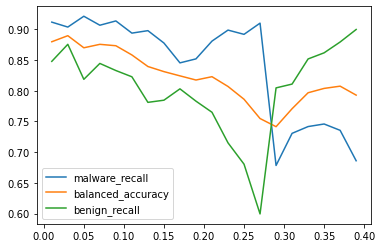

In [68]:
plt.plot(df['thres'],df['malware_recall'],label='malware_recall')
plt.plot(df['thres'],df['balanced_accuracy'],label='balanced_accuracy')
plt.plot(df['thres'],df['benign_recall'],label='benign_recall')
# plt.plot(df['thres'],df['benign_precision'],label='benign_precision')
# plt.plot(df['thres'],df['malware_precision'],label='malware_precision')
plt.legend()

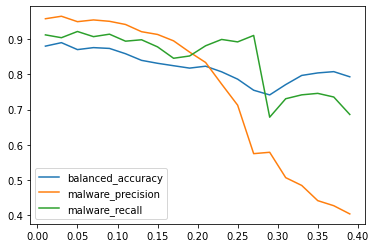

In [69]:
plt.plot(df['thres'],df['balanced_accuracy'],label='balanced_accuracy')
plt.plot(df['thres'],df['malware_precision'],label='malware_precision')

plt.plot(df['thres'],df['malware_recall'],label='malware_recall')

# plt.plot(df['thres'],df['benign_recall'],label='benign_recall')
# plt.plot(df['thres'],df['benign_precision'],label='benign_precision')
plt.legend()

In [72]:
import collections
# pd_metric=collections.defaultdict(list)
for thres in list(np.arange(17,26,1)):
    print('------thres=',thres)
    score,recall1,recall2,precision1,precision2=compute_metric_thres(X_train.drop('proportion',axis=1),
                                                                     X_test.drop('proportion',axis=1),thres,['malwareNum','label'],2)
    pd_metric['thres'].append(thres)
    pd_metric['balanced_accuracy'].append(score)
    pd_metric['benign_recall'].append(recall1)
    pd_metric['malware_recall'].append(recall2)
    pd_metric['benign_precision'].append(precision1)
    pd_metric['malware_precision'].append(precision2)

------thres= 17
0.27706422018348625
0.2688679245283019
balanced acc=0.7474816072439163  recall_benign=0.810752688172043  recall_malware=0.6842105263157895
------thres= 18
0.2182175622542595
0.2112159329140461
balanced acc=0.7822428134506154  recall_benign=0.812624584717608  recall_malware=0.7518610421836228
------thres= 19
0.1817824377457405
0.17033542976939203
balanced acc=0.7950755624665922  recall_benign=0.8332280480101074  recall_malware=0.7569230769230769
------thres= 20
0.15176933158584535
0.139937106918239
balanced acc=0.7912549897637094  recall_benign=0.8671541742839732  recall_malware=0.7153558052434457
------thres= 21
0.13171690694626476
0.11740041928721175
balanced acc=0.8113282575500509  recall_benign=0.8592636579572447  recall_malware=0.7633928571428571
------thres= 22
0.11507208387942333
0.10377358490566038
balanced acc=0.8097022860180756  recall_benign=0.8719298245614036  recall_malware=0.7474747474747475
------thres= 23
0.0981651376146789
0.08962264150943396
balanced ac

In [71]:
pd_metric

defaultdict(list,
            {'thres': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
             'balanced_accuracy': [0.8823969251039043,
              0.8680678629449121,
              0.8448637316561844,
              0.83506646951034,
              0.8257642844959918,
              0.8109771181199752,
              0.8041378182412909,
              0.8187374822286563,
              0.8302835749419288,
              0.7993311386032502,
              0.7707190505731385,
              0.7451151328605938],
             'benign_recall': [0.8568019093078759,
              0.831081081081081,
              0.7756813417190775,
              0.7833001988071571,
              0.7729831144465291,
              0.7568027210884354,
              0.7616892911010558,
              0.7804551539491299,
              0.7723970944309927,
              0.6973262032085561,
              0.6310772163965681,
              0.603035143769968],
             'malware_recall': [0.9079919408999328,
           

In [ ]:
pd.DataFrame(pd_metric).to_csv('../../dnn_threshold_count.csv',index=False)
df=pd.DataFrame(pd_metric)

In [ ]:
plt.plot(df['thres'],df['malware_recall'],label='malware_recall')
plt.plot(df['thres'],df['balanced_accuracy'],label='balanced_accuracy')
plt.plot(df['thres'],df['benign_recall'],label='benign_recall')
# plt.plot(df['thres'],df['benign_precision'],label='benign_precision')
# plt.plot(df['thres'],df['malware_precision'],label='malware_precision')
plt.legend()

In [39]:
plt.plot(df['thres'],df['balanced_accuracy'],label='balanced_accuracy')
plt.plot(df['thres'],df['malware_precision'],label='malware_precision')
plt.plot(df['thres'],df['malware_recall'],label='malware_recall')
# plt.plot(df['thres'],df['benign_recall'],label='benign_recall')
# plt.plot(df['thres'],df['benign_precision'],label='benign_precision')
plt.legend()